In [1]:
import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import pdb
import json

In [7]:
# input image
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'http://media.mlive.com/news_impact/photo/9933031-large.jpg'
# 使用本地的图片和下载到本地的labels.json文件
# LABELS_PATH = "labels.json"
# networks such as googlenet, resnet, densenet already use global average pooling at the end, so CAM could be used directly.
model_id = 2
# 选择使用的网络
if model_id == 1:
 net = models.squeezenet1_1(pretrained=True)
 finalconv_name = 'features' # this is the last conv layer of the network
elif model_id == 2:
 net = models.resnet18(pretrained=True)
 finalconv_name = 'layer4'
elif model_id == 3:
 net = models.densenet161(pretrained=True)
 finalconv_name = 'features'
# 有固定参数的作用，如norm的参数
net.eval()
# 获取特定层的feature map
# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
net._modules.get(finalconv_name).register_forward_hook(hook_feature)
# 得到softmax weight,
params = list(net.parameters()) # 将参数变换为列表
weight_softmax = np.squeeze(params[-2].data.numpy()) # 提取softmax 层的参数
# 生成CAM图的函数，完成权重和feature相乘操作
# CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape # 获取feature_conv特征的尺寸
    output_cam = []
    # class_idx为预测分值较大的类别的数字表示的数组，一张图片中有N类物体则数组中N个元素
    for idx in class_idx:
    # weight_softmax中预测为第idx类的参数w乘以feature_map(为了相乘，故reshape了map的形状)
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        # 将feature_map的形状reshape回去
        cam = cam.reshape(h, w)
        # 归一化操作（最小的值为0，最大的为1）
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        # 转换为图片的255的数据
        cam_img = np.uint8(255 * cam_img)
        # resize 图片尺寸与输入图片一致
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam
# 数据处理，先缩放尺寸到（224*224），再变换数据类型为tensor,最后normalize
normalize = transforms.Normalize(
 mean=[0.485, 0.456, 0.406],
 std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
 transforms.Resize((224,224)),
 transforms.ToTensor(),
 normalize
])
# 通过requests库获取图片并保存，若是本地图片则只需要设置本地图片的保存地址，以便后来提取便好
# img_path = "/../..jpg"
# img_pil = Image.open(img_path)
response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
img_pil.save('test.jpg')
# 将图片数据处理成所需要的可用的数据
img_tensor = preprocess(img_pil)
# 处理图片为Variable数据
img_variable = Variable(img_tensor.unsqueeze(0))
# 将图片输入网络得到预测类别分值
logit = net(img_variable)
# download the imagenet category list
# 下载imageNet 分类标签列表，并存储在classes中（数字类别，类别名称）
classes = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}
# # 使用本地的 LABELS_PATH
# with open(LABELS_PATH) as f:
# data = json.load(f).items()
# classes = {int(key):value for (key, value) in data}
# 使用softmax打分
h_x = F.softmax(logit, dim=1).data.squeeze() # 分类分值
# 对分类的预测类别分值排序，输出预测值和在列表中的位置
probs, idx = h_x.sort(0, True) 
# 转换数据类型
probs = probs.numpy()
idx = idx.numpy()
# 输出预测分值排名在前五的五个类别的预测分值和对应类别名称
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
# generate class activation mapping for the top1 prediction
# 输出与图片尺寸一致的CAM图片
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])
# render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
# 将图片和CAM拼接在一起展示定位结果结果
img = cv2.imread('test.jpg')
height, width, _ = img.shape
# 生成热度图
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM.jpg', result)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

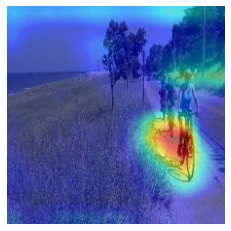

In [14]:
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torch.autograd import Function
from torchvision import models
from torchvision import utils
import cv2
import sys
import numpy as np


class FeatureExtractor():
    """ 
    Class for extracting activations and
        registering gradients from targetted intermediate layers 
    """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x


class ModelOutputs():
    """ 
    Class for making a forward pass, and getting:
        1. The network output.
        2. Activations from intermeddiate targetted layers.
        3. Gradients from intermeddiate targetted layers. 
    """

    def __init__(self, model, target_layers):
        self.model = model
        self.feature_extractor = FeatureExtractor(self.model.features, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations, output = self.feature_extractor(x)
        output = output.view(output.size(0), -1)
        output = self.model.classifier(output)
        return target_activations, output


def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = Variable(preprocessed_img, requires_grad=True)
    return input


def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    cv2.imwrite("./grad_cam.jpg", np.uint8(255 * cam))
    plt.imshow(Image.open('./grad_cam.jpg'))
    plt.axis('off')
    plt.show()


class GradCam:
    def __init__(self, model, target_layer_names, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, target_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = Variable(torch.from_numpy(one_hot), requires_grad=True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

if __name__ == '__main__':
    image_path = './test.jpg'
    # Can work with any model, but it assumes that the model has a
    # feature method, and a classifier method,
    # as in the VGG models in torchvision.
    grad_cam = GradCam(model=models.vgg19(pretrained=True), target_layer_names=["35"], use_cuda=False)

    img = cv2.imread(image_path, 1)
    img = np.float32(cv2.resize(img, (224, 224))) / 255
    input = preprocess_image(img)

    # If None, returns the map for the highest scoring category.
    # Otherwise, targets the requested index.
    target_index = None

    mask = grad_cam(input, target_index)
    
    show_cam_on_image(img, mask)